In [1]:
# MATH80629 Project
# Alban Delerue
# Fall 2020

# <font color = "red"> Tweet Classification </font>

In [11]:
# import of necessary packages
import numpy as np
import pandas as pd
import nltk
import time
import subprocess
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import winsound

In [4]:
train = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")

In [5]:
test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")['OriginalTweet']
y_test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")['Sentiment']

## Exploratory Data Analysis

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Neutral'),
  Text(1, 0, 'Positive'),
  Text(2, 0, 'Extremely Negative'),
  Text(3, 0, 'Negative'),
  Text(4, 0, 'Extremely Positive')])

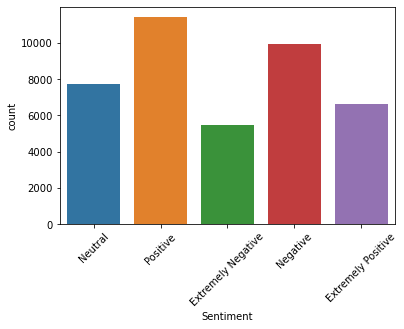

In [10]:
sns.countplot(x='Sentiment', data=train)
plt.xticks(rotation = 45)

<AxesSubplot:ylabel='Frequency'>

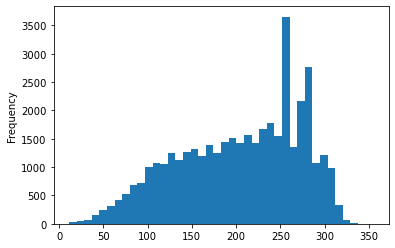

In [11]:
# Length of the tweets
train['OriginalTweet'].apply(len).plot(bins=40, kind='hist') 

In [12]:
# Benchmark:

In [13]:
train.groupby("Sentiment")["UserName"].count()
# The accuracy of a model that predicts "Positive" as the sentiment of every example will be 0.28%.

Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
Name: UserName, dtype: int64

In [14]:
# Percentage of each category
round(train["Sentiment"].value_counts(normalize = True) * 100, 2)

Positive              27.75
Negative              24.10
Neutral               18.74
Extremely Positive    16.09
Extremely Negative    13.32
Name: Sentiment, dtype: float64

In [15]:
# Split the train dataset into train and validation datasets:

In [89]:
from sklearn.model_selection import train_test_split

In [6]:
train, validation, y_train, y_validation = train_test_split(train['OriginalTweet'],train['Sentiment'],
                                                            test_size = 0.4, random_state=1234)

## Text Cleaning & Preprocessing

In [18]:
# Convert strings to lowercase:

In [7]:
train = train.str.lower()
validation = validation.str.lower()
test = test.str.lower()

In [26]:
# Remove Urls and HTML links:

In [13]:
def remove_urls(text3):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text3)

In [14]:
def remove_html(text4):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text4)

In [15]:
train = train.apply(remove_urls)
train = train.apply(remove_html)

validation = validation.apply(remove_urls)
validation = validation.apply(remove_html)

test = test.apply(remove_urls)
test = test.apply(remove_html)

In [21]:
# !pip install emoji
# !pip install emot
# Allows to translate emojis and emoticons into text describing the emotion behind it
try:
    import emoji
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", 'emoji', "emot"])
finally:
    import emoji, emot

In [92]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [93]:
def emojis_to_word(text1):
    for emot in UNICODE_EMO:
        text1 = text1.replace(emot, "_".join(UNICODE_EMO[emot].
                                             replace(",","").replace(":","").split()))
    return text1

In [94]:
def emoticons_to_word(text2):
    for emot in EMOTICONS:
        text2 = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].
                                               replace(",","").split()), text2)
    return text2

In [95]:
train = train.apply(emojis_to_word)
train = train.apply(emoticons_to_word)

test = test.apply(emojis_to_word)
test = test.apply(emoticons_to_word)

validation = validation.apply(emojis_to_word)
validation = validation.apply(emoticons_to_word)

In [30]:
# Remove digits:

In [16]:
def remove_digits(text5):
    text5 = re.sub(r"\d+\S+", ' ', text5)
    return text5

In [17]:
train = train.apply(remove_digits)
validation = validation.apply(remove_digits)
test = test.apply(remove_digits)

In [33]:
# Remove peoples' usernames:

In [18]:
def remove_usernames(text6):
    text6 = re.sub(r"@\w+", ' ', text6)
    return text6

In [19]:
train = train.apply(remove_usernames)
validation = validation.apply(remove_usernames)
test = test.apply(remove_usernames)

In [36]:
# Remove the punctuation:

In [20]:
import string

In [21]:
def remove_punctuation(text7):
    text7 = ''.join([char for char in text7 if char not in string.punctuation])
    return text7

In [22]:
train = train.apply(remove_punctuation)
validation = validation.apply(remove_punctuation)
test = test.apply(remove_punctuation)

In [40]:
# Remove stop words:

In [25]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\albdl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
def remove_stopwords(text8):
    text8 = " ".join([word for word in text8.split() if word not in stopwords.words('english')])
    return text8

In [27]:
train = train.apply(remove_stopwords)
validation = validation.apply(remove_stopwords)
test = test.apply(remove_stopwords)

In [44]:
# Replace some important words:

In [28]:
def replace_important_words(tweet9):
    tweet9 = re.sub(r" usa ", " america ", tweet9)
    tweet9 = re.sub(r" u s ", " america ", tweet9)
    tweet9 = re.sub(r" uk ", " england ", tweet9)
    tweet9 = re.sub(r" US ", " america ", tweet9)
    tweet9 = re.sub(r"usagov", "usa government", tweet9)
    tweet9 = re.sub(r"coronavirus", " covid19 ", tweet9)
    return tweet9

In [29]:
train = train.apply(replace_important_words)
validation = validation.apply(replace_important_words)
test = test.apply(replace_important_words)

In [30]:
# Backing up the data with a deep copy of the dataframes
train_backup = train.copy()
validation_backup = validation.copy()
test_backup = test.copy()

In [48]:
# Converting Text to Numerical Vector:

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tfidf_vect = TfidfVectorizer(min_df=10)
tfidf_vect.fit(train)

TfidfVectorizer(min_df=10)

In [33]:
x_train = tfidf_vect.transform(train)
print("Train: ", x_train.get_shape())

x_validation = tfidf_vect.transform(validation)
print("Validation: ", x_validation.get_shape())

x_test = tfidf_vect.transform(test)
print("Test: ", x_test.get_shape())

Train:  (24694, 4695)
Validation:  (16463, 4695)
Test:  (3798, 4695)


## Modeling

### 1) Support vector machine:

In [34]:
from sklearn.svm import SVC 

Training time: 97.044253s; Prediction time: 52.218237s
                    precision    recall  f1-score   support

Extremely Negative       0.66      0.52      0.58      2168
Extremely Positive       0.72      0.58      0.65      2611
          Negative       0.53      0.57      0.55      3978
           Neutral       0.66      0.68      0.67      3162
          Positive       0.57      0.64      0.60      4544

          accuracy                           0.61     16463
         macro avg       0.63      0.60      0.61     16463
      weighted avg       0.61      0.61      0.61     16463



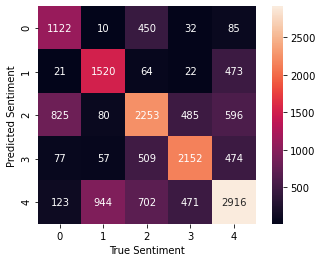

In [151]:
model_SVM = SVC(kernel='linear', C=1)
t0 = time.time()
model_SVM.fit(x_train, y_train)
t1 = time.time()

Predictions_SVM = model_SVM.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1


print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(y_validation, Predictions_SVM))

mat = confusion_matrix(y_validation, Predictions_SVM)
sns.heatmap(mat.T, square = True, annot = True, fmt ='d')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

winsound.Beep(1500, 1000)

In [ ]:
# Find best hyperparameters by GridSearch:

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
hyperparams = {'kernel': ['rbf', 'linear' , 'poly'] , 'gamma': ['scale', 'auto'] , 
              'C': [0.1 , 1 , 10]}

tuner = GridSearchCV(SVC() , hyperparams , scoring ='accuracy' , n_jobs=-1)
tuner.fit(x_train, y_train)

print(tuner.best_params_)
winsound.Beep(1500, 1000)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Model with the obtained hyperparameters:
# for gamma, default=’scale’

Training time: 403.416345s; Prediction time: 60.740616s
                    precision    recall  f1-score   support

Extremely Negative       0.69      0.52      0.60      2168
Extremely Positive       0.73      0.59      0.65      2611
          Negative       0.54      0.57      0.56      3978
           Neutral       0.67      0.65      0.66      3162
          Positive       0.55      0.66      0.60      4544

          accuracy                           0.61     16463
         macro avg       0.64      0.60      0.61     16463
      weighted avg       0.62      0.61      0.61     16463



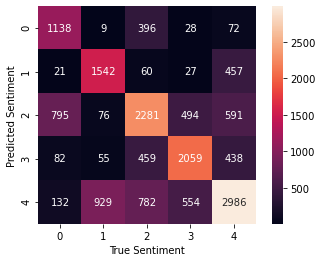

In [152]:
model_SVM = SVC(kernel='rbf', C=10)
t0 = time.time()
model_SVM.fit(x_train, y_train)
t1 = time.time()

Predictions_SVM = model_SVM.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1


print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(y_validation, Predictions_SVM))

mat = confusion_matrix(y_validation, Predictions_SVM)
sns.heatmap(mat.T, square=True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

winsound.Beep(1500, 1000)

In [ ]:
# Redefine the sentiments into 3 categories:

In [35]:
def classes_def(category):
    if category ==  "Extremely Positive" or category ==  "Positive" :
        return "Positive"
    elif category == "Extremely Negative" or category ==  "Negative" :      
        return "Negative"
    elif category == "Neutral" :
        return "Neutral"

In [36]:
new_y_train = y_train.apply(lambda x:classes_def(x))
new_y_validation = y_validation.apply(lambda x:classes_def(x))
new_y_test = y_test.apply(lambda x:classes_def(x))

Training time: 366.435681s; Prediction time: 45.060211s
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79      6146
     Neutral       0.71      0.61      0.66      3162
    Positive       0.80      0.85      0.82      7155

    accuracy                           0.78     16463
   macro avg       0.77      0.75      0.75     16463
weighted avg       0.78      0.78      0.78     16463



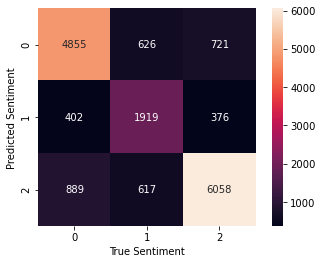

In [37]:
new_model_SVM = SVC(kernel='rbf', C=10)
t0 = time.time()
new_model_SVM.fit(x_train, new_y_train)
t1 = time.time()
new_Predictions_SVM = new_model_SVM.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(new_y_validation, new_Predictions_SVM))

mat = confusion_matrix(new_y_validation, new_Predictions_SVM)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

winsound.Beep(1500, 1000)

In [1]:
# Classification on the test set

In [38]:
t1 = time.time()
predictions_SVM_3_test = new_model_SVM.predict(x_test)
t2 = time.time()
time_prediction = t2-t1a

print("Prediction time: %fs" % (time_prediction))
print(classification_report(new_y_test, predictions_SVM_3_test))

Prediction time: 10.748824s
              precision    recall  f1-score   support

    Negative       0.78      0.77      0.77      1633
     Neutral       0.67      0.59      0.62       619
    Positive       0.78      0.82      0.80      1546

    accuracy                           0.76      3798
   macro avg       0.74      0.73      0.73      3798
weighted avg       0.76      0.76      0.76      3798



### 2) Multinomial Naive Bayes

In [63]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Base model with 5 classes

In [164]:
clf_NB_5classes = MultinomialNB()
t0 = time.time()
clf_NB_5_fit = clf_NB_5classes.fit(x_train, y_train)
t1 = time.time()
predictions_train_NB_5 = clf_NB_5_fit.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(y_validation, predictions_train_NB_5))

Training time: 0.060871s; Prediction time: 0.002991s
                    precision    recall  f1-score   support

Extremely Negative       0.71      0.17      0.27      2168
Extremely Positive       0.67      0.25      0.36      2611
          Negative       0.42      0.51      0.46      3978
           Neutral       0.63      0.35      0.45      3162
          Positive       0.39      0.73      0.51      4544

          accuracy                           0.45     16463
         macro avg       0.56      0.40      0.41     16463
      weighted avg       0.53      0.45      0.43     16463



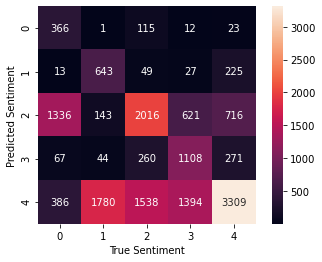

In [161]:
mat = confusion_matrix(y_validation, predictions_train_NB_5)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

In [158]:
# Predictions on the test set

In [156]:
pd.set_option('display.max_colwidth', None)

In [163]:
test.head(1)

0    trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery  covid19 fearing shoppers stock
Name: OriginalTweet, dtype: object

In [168]:
t1 = time.time()
predictions_test_NB_5 = clf_NB_5_fit.predict(x_test)
t2 = time.time()
time_prediction = t2-t1

print("Prediction time: %fs" % (time_prediction))
print(classification_report(y_test, predictions_test_NB_5))

Prediction time: 0.001962s
                    precision    recall  f1-score   support

Extremely Negative       0.71      0.14      0.24       592
Extremely Positive       0.72      0.18      0.29       599
          Negative       0.42      0.50      0.45      1041
           Neutral       0.55      0.31      0.39       619
          Positive       0.36      0.74      0.48       947

          accuracy                           0.42      3798
         macro avg       0.55      0.37      0.37      3798
      weighted avg       0.52      0.42      0.39      3798



In [ ]:
# Model with only 3 categories

In [176]:
clf_3classes = MultinomialNB()
t0 = time.time()
clf_NB_3_fit = clf_3classes.fit(x_train, new_y_train)
t1 = time.time()
predictions_NB_3_valid = clf_NB_3_fit.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(new_y_validation, predictions_NB_3_valid))

Training time: 0.058873s; Prediction time: 0.001994s
              precision    recall  f1-score   support

    Negative       0.70      0.70      0.70      6146
     Neutral       0.72      0.16      0.26      3162
    Positive       0.63      0.85      0.72      7155

    accuracy                           0.66     16463
   macro avg       0.68      0.57      0.56     16463
weighted avg       0.67      0.66      0.62     16463



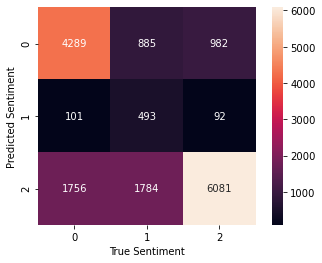

In [178]:
mat = confusion_matrix(new_y_validation, predictions_NB_3_valid)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

In [80]:
# Predictions on the test set

In [180]:
t1 = time.time()
predictions_NB_3_test = clf_NB_3_fit.predict(x_test)
t2 = time.time()
time_prediction = t2-t1

print("Prediction time: %fs" % (time_prediction))
print(classification_report(new_y_test, predictions_NB_3_test))

Prediction time: 0.002549s
              precision    recall  f1-score   support

    Negative       0.73      0.71      0.72      1633
     Neutral       0.61      0.13      0.21       619
    Positive       0.63      0.84      0.72      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.56      0.55      3798
weighted avg       0.67      0.67      0.64      3798



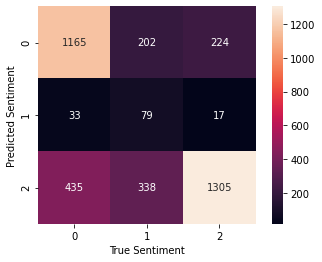

In [181]:
mat = confusion_matrix(new_y_test, predictions_NB_3_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

### 3) Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
clf_randomForest = RandomForestClassifier()

In [68]:
t0 = time.time()
clf_fit = clf_randomForest.fit(x_train, y_train)
t1 = time.time()
predictions = clf_fit.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(y_validation, predictions))

Training time: 34.407799s; Prediction time: 0.799861s
                    precision    recall  f1-score   support

Extremely Negative       0.61      0.44      0.51      2168
Extremely Positive       0.61      0.45      0.52      2611
          Negative       0.47      0.43      0.45      3978
           Neutral       0.53      0.67      0.59      3162
          Positive       0.46      0.53      0.49      4544

          accuracy                           0.51     16463
         macro avg       0.53      0.51      0.51     16463
      weighted avg       0.52      0.51      0.51     16463



In [ ]:
# With gridsearch

In [69]:
# gridsearch to find best parameters
hyperparams = {"n_estimators": [50, 100, 150, 200, 500, 1000],
               "criterion": ["gini", "entropy"]}

In [70]:
tuner = GridSearchCV(RandomForestClassifier(), hyperparams, scoring = "accuracy", n_jobs= -1)
tuner.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000]},
             scoring='accuracy')

In [71]:
print(tuner.best_params_)

{'criterion': 'entropy', 'n_estimators': 1000}


In [ ]:
# With best parameters, 5 classes

In [184]:
model_randomForest_5 = RandomForestClassifier(n_estimators = 500, criterion = "gini")
t0 = time.time()
model_fit_5 = model_randomForest.fit(x_train, y_train)
t1 = time.time()
predictions_RF_5_valid = model_fit_5.predict(x_validation)
t2 = time.time()
time_train = t1-t0
time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(y_validation, predictions_RF_5_valid))

Training time: 177.696579s; Prediction time: 4.151140s
                    precision    recall  f1-score   support

Extremely Negative       0.61      0.44      0.51      2168
Extremely Positive       0.63      0.44      0.52      2611
          Negative       0.49      0.44      0.46      3978
           Neutral       0.53      0.69      0.60      3162
          Positive       0.46      0.55      0.50      4544

          accuracy                           0.52     16463
         macro avg       0.54      0.51      0.52     16463
      weighted avg       0.53      0.52      0.52     16463



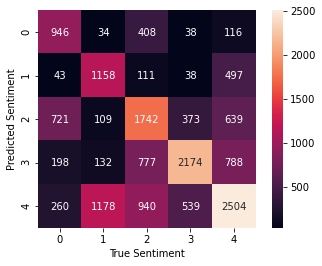

In [190]:
mat = confusion_matrix(y_validation, predictions_RF_5_valid)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

In [183]:
# Predictions on test set

In [187]:
t1 = time.time()
predictions_RF_5_test = model_fit_5.predict(x_test)
t2 = time.time()
time_prediction = t2-t1

print("Prediction time: %fs" % (time_prediction))
print(classification_report(y_test, predictions_RF_5_test))

Prediction time: 0.983874s
                    precision    recall  f1-score   support

Extremely Negative       0.52      0.36      0.43       592
Extremely Positive       0.64      0.43      0.51       599
          Negative       0.43      0.38      0.40      1041
           Neutral       0.48      0.66      0.56       619
          Positive       0.41      0.53      0.46       947

          accuracy                           0.47      3798
         macro avg       0.50      0.47      0.47      3798
      weighted avg       0.48      0.47      0.46      3798



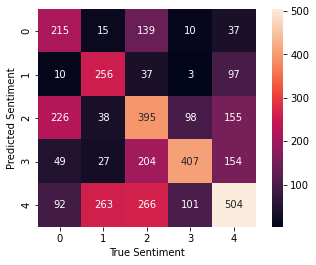

In [191]:
mat = confusion_matrix(y_test, predictions_RF_5_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

In [ ]:
# Using only 3 classes of sentiments instead of 5

In [193]:
model_randomForest_3 = RandomForestClassifier(n_estimators = 500, criterion = "gini")
t0 = time.time()
model_fit_3_valid = model_randomForest_3.fit(x_train, new_y_train)
t1 = time.time()
predictions_RF_3_valid = model_fit_3_valid.predict(x_validation)
t2 = time.time()
time_train = t1-t0

time_prediction = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_train, time_prediction))
print(classification_report(new_y_validation, predictions_RF_3_valid ))

Training time: 137.173077s; Prediction time: 3.526648s
              precision    recall  f1-score   support

    Negative       0.72      0.70      0.71      6146
     Neutral       0.61      0.59      0.60      3162
    Positive       0.74      0.78      0.76      7155

    accuracy                           0.71     16463
   macro avg       0.69      0.69      0.69     16463
weighted avg       0.71      0.71      0.71     16463



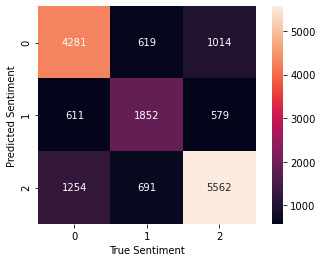

In [197]:
mat = confusion_matrix(new_y_validation, predictions_RF_3_valid)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');

In [ ]:
# Predictions on 3 classes for the test set

In [198]:
t1 = time.time()
predictions_RF_3_test = model_fit_3.predict(x_test)
t2 = time.time()
time_prediction = t2-t1

print("Prediction time: %fs" % (time_prediction))
print(classification_report(new_y_test, predictions_RF_3_test))

Prediction time: 0.895975s
              precision    recall  f1-score   support

    Negative       0.71      0.68      0.70      1633
     Neutral       0.54      0.55      0.55       619
    Positive       0.71      0.74      0.73      1546

    accuracy                           0.68      3798
   macro avg       0.65      0.66      0.66      3798
weighted avg       0.68      0.68      0.68      3798



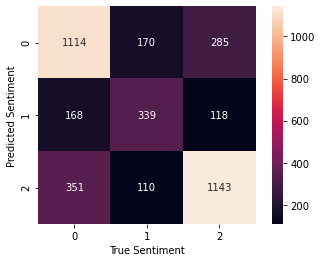

In [199]:
mat = confusion_matrix(new_y_test, predictions_RF_3_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd')
plt.xlabel('True Sentiment')
plt.ylabel('Predicted Sentiment');